# Centrifugal Pump (CP)
March 9th, 2025
Data analysis by Alex Quemel, Rahil Shaik, Sneha Kancharla, and Ethan Mibu

In [140]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from scipy.optimize import curve_fit
import warnings
warnings.filterwarnings('ignore')

### Reading in Data from .csv

In [141]:
df = pd.read_csv("MW1-Centrifugal Pump Lab Raw Data - Sheet1.csv")

In [142]:
df

,impeller_diam,motor_speed,ext_fpm,field_voltage,armature_voltage,field_current,armature_current,pump_suction_pressure,pump_discharge_pressure,drive_shaft_torque,flowrate
0,3.500,50,2907.8,139,134,280,2.20,1.3,5.50,5.00,21.5000
1,3.500,40,2317.5,139,107,280,1.89,1.7,5.00,3.20,19.0000
2,3.500,30,1717.9,139,81,280,1.38,2.1,4.25,2.00,17.0000
3,3.500,20,1120.2,138,54,280,1.10,2.5,4.00,1.00,10.5000
4,3.500,10,519.2,138,22,280,0.80,2.6,3.50,0.95,0.0014
5,4.500,50,2770.0,140,130,300,3.60,1.0,6.80,10.50,28.0000
6,4.500,40,2252.0,140,105,290,2.62,1.1,5.80,7.00,26.0000
7,4.500,30,1673.5,140,80,290,1.90,1.7,5.00,4.00,20.7500
8,4.500,20,1074.8,140,50,285,1.30,2.4,4.00,2.00,14.5000
9,4.500,10,487.8,140,25,285,1.00,2.6,4.00,1.00,1.0000


### Pre-Processing

Converting our flow rate to a volumetric flow rate in m^3 / sec:

$$ \text{flow rate in } \frac{\text{gallon}}{\text{min}} = \frac{6.309 \times 10^-5 \text{cubic meters}}{\text{gallon}} \times \frac{\text{1 min}}{\text{60 sec}}$$

In [143]:
df["volumetric_flowrate"] = df["flowrate"] * 6.309 * 10 ** -5 * (1 / 60) # m^3/s

converting inches to meters

$$ 39.37 \ \text{in} = 1 \ \text{m}$$

In [144]:
df["impeller_diam_meters"] = df["impeller_diam"] * (1/39.37)

## Analysis Question 1
$$ \textbf {For one impeller, plot head versus capacity with rotational speed as a parameter (See
references for determining head and capacity.)} $$

To start this question, we need to compute pump head for an impeller. Let's start with the 3.5 inch diameter impeller. 

The pump head is defined as the "height which the pump will lift fluid at a given flow rate" (Noel de Nevers, 3) which we can equate by
 
$$ h = \frac{P_{4} - P_{1}}{\rho * g} $$ 

(Noel de Nevers, eqn 10.20) 

We will define P_4 as the pump discharge pressure and P_1 as the pump suction pressure.

In [145]:
rho = 997 #kg/m^3
g = 9.81 #m/s^2

In [146]:
df["pump_head"] = (df["pump_discharge_pressure"] - df["pump_suction_pressure"]) / (rho * g)

Now let's plot this pump head against capacity which we know is the same as head-flowrate (McCabe-Smith, 202)

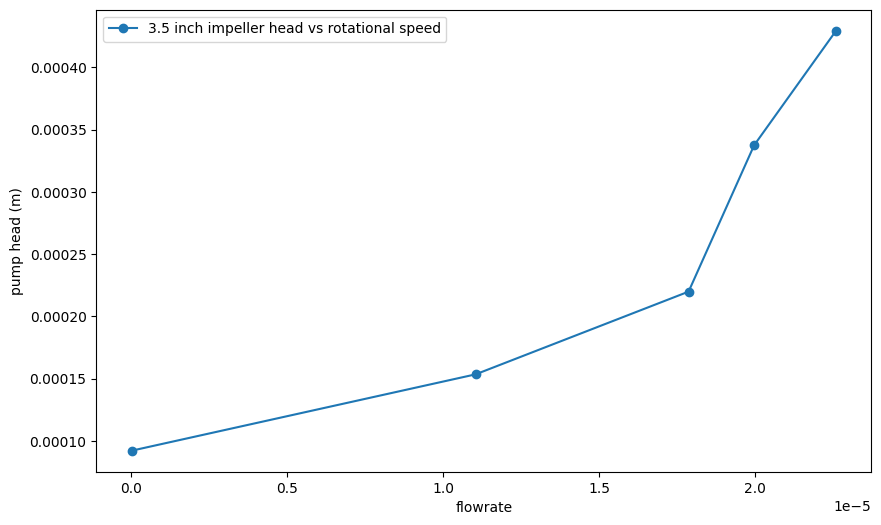

In [147]:
df_small = df.query("impeller_diam == 3.500")

plt.figure(figsize=(10,6))
plt.plot(df_small["volumetric_flowrate"], df_small["pump_head"], marker="o", label="3.5 inch impeller head vs rotational speed")
plt.xlabel("flowrate")
plt.ylabel("pump head (m)")
plt.legend()

Let's plot the rest of the impeller sizes to ensure that this is the correct shape we should be looking for

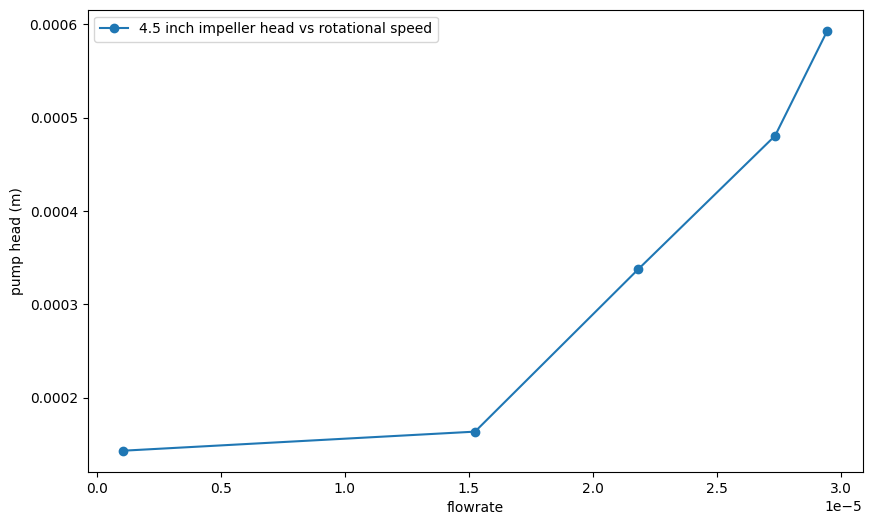

In [148]:
df_med = df.query("impeller_diam == 4.500")

plt.figure(figsize=(10,6))
plt.plot(df_med["volumetric_flowrate"], df_med["pump_head"], marker="o", label="4.5 inch impeller head vs rotational speed")
plt.xlabel("flowrate")
plt.ylabel("pump head (m)")
plt.legend()

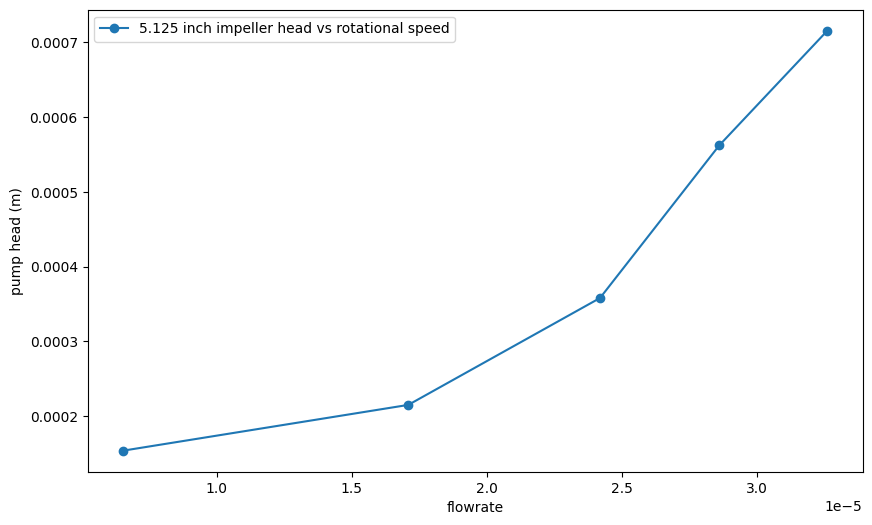

In [149]:
df_big = df.query("impeller_diam == 5.125")

plt.figure(figsize=(10,6))
plt.plot(df_big["volumetric_flowrate"], df_big["pump_head"], marker="o", label="5.125 inch impeller head vs rotational speed")
plt.xlabel("flowrate")
plt.ylabel("pump head (m)")
plt.legend()

Now, we have a good sense of the shape, it is best reprsented by the 5.125 inch impeller so we will use this going forward. Let's synthesize a quantitative relationship that describes effect of rotational speed on head. The relationship appears polynomial, so we can fit a polynomial regression to this line. 

In [150]:
X = df_big[["volumetric_flowrate"]].values 
y = df_big["pump_head"].values

In [151]:
X_quad = np.hstack((X, X**2))
model = LinearRegression()
model.fit(X_quad, y)

a, b = model.coef_[1], model.coef_[0]
c = model.intercept_

X_fit = np.linspace(X.min(), X.max(), 100).reshape(-1, 1)
X_fit_quad = np.hstack((X_fit, X_fit**2))
y_fit = model.predict(X_fit_quad)


In [152]:
def cubic(N, a, b, c, d):
    return a * N**3 + b * N**2 + c * N + d

popt_cubic, _ = curve_fit(cubic, X.flatten(), y)
y_fit_cubic = cubic(X_fit.flatten(), *popt_cubic)


ADD ERROR BARS

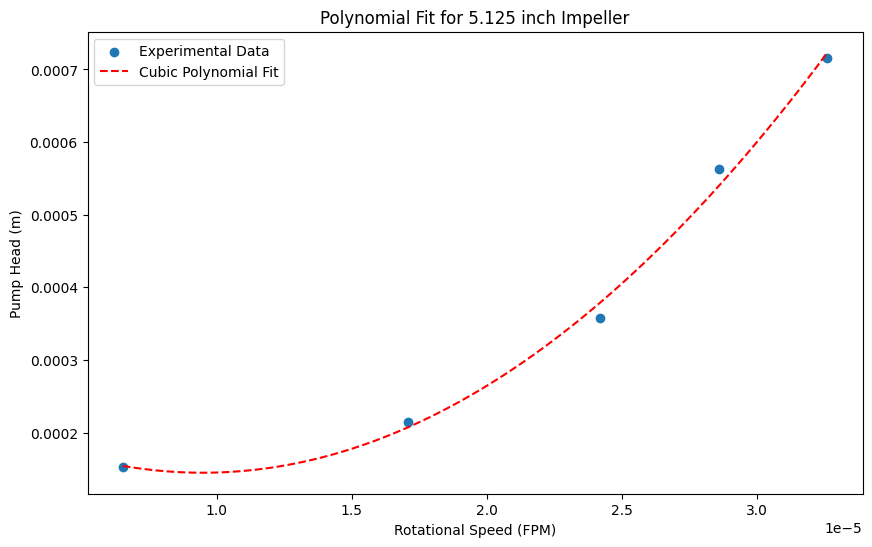

'Poly Fit Eqn = 1.032173e+00N³ + 1.081355e+06N² + -2.048872e+01N + 2.418646e-04'

In [153]:
plt.figure(figsize=(10,6))
plt.scatter(X, y, label="Experimental Data")
plt.plot(X_fit, y_fit_cubic, label="Cubic Polynomial Fit", color="red", linestyle="--")
plt.xlabel("Rotational Speed (FPM)")
plt.ylabel("Pump Head (m)")
plt.title(f"Polynomial Fit for {5.125} inch Impeller")
plt.legend()
plt.show()

cubic_eq = f"Poly Fit Eqn = {popt_cubic[0]:.6e}N³ + {popt_cubic[1]:.6e}N² + {popt_cubic[2]:.6e}N + {popt_cubic[3]:.6e}"

cubic_eq


So, we can synthesize a head(fpm) expression of 

$$
h(fpm) = -0.00000000192 fpm^{3} + 0.00000206 fpm^{2} -0.0000217 fpm + 0.00024
$$

## Analysis Question 2

$$ \textbf{Prepare a plot of head as a function of capacity for a single rpm.} $$

motor speed and RPM are analagous so we will partition our dataframe on 50 V motor speed

In [154]:
df_50 = df.query("motor_speed == 50")

Text(0, 0.5, 'pump head (m)')

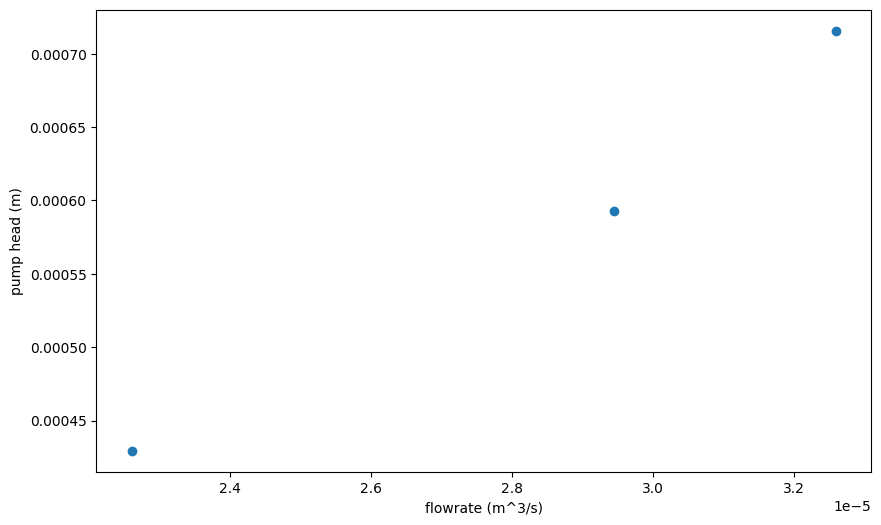

In [155]:
plt.figure(figsize=(10,6))
plt.scatter(df_50["volumetric_flowrate"], df_50["pump_head"], marker="o")
plt.xlabel("flowrate (m^3/s)")
plt.ylabel("pump head (m)")


Let's check the head-capacity relationship for all motor speeds

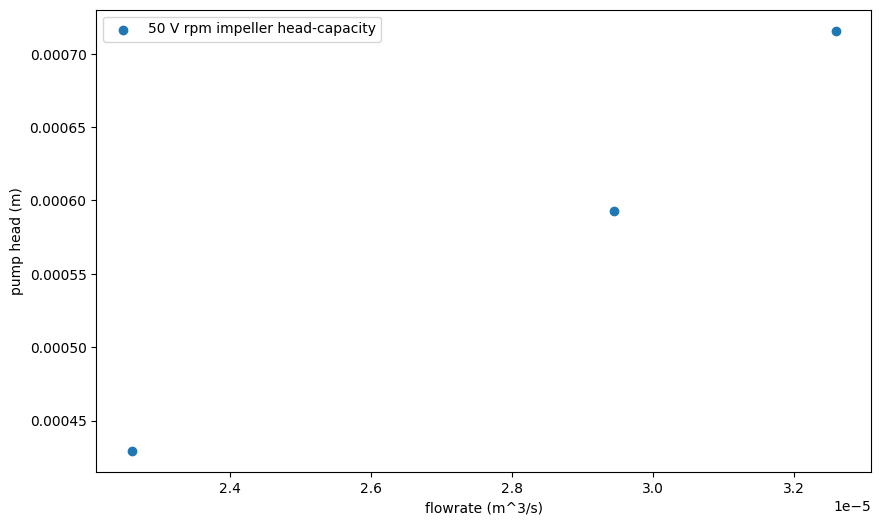

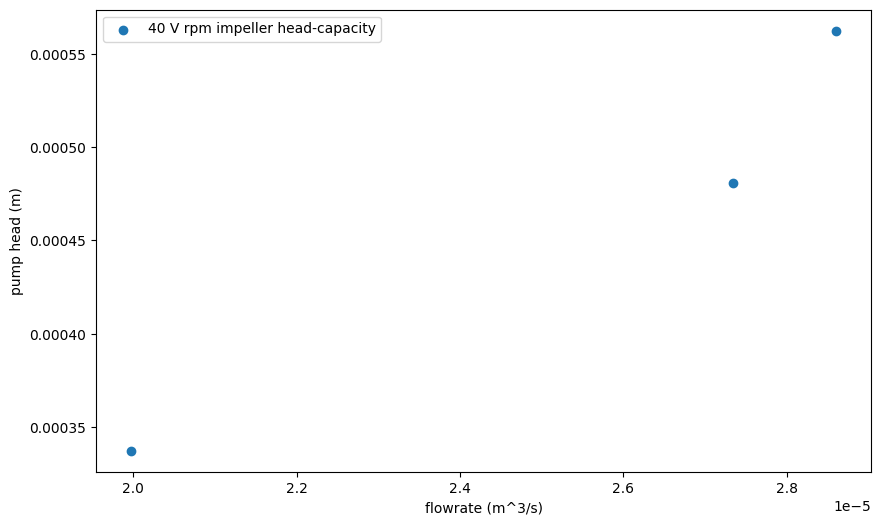

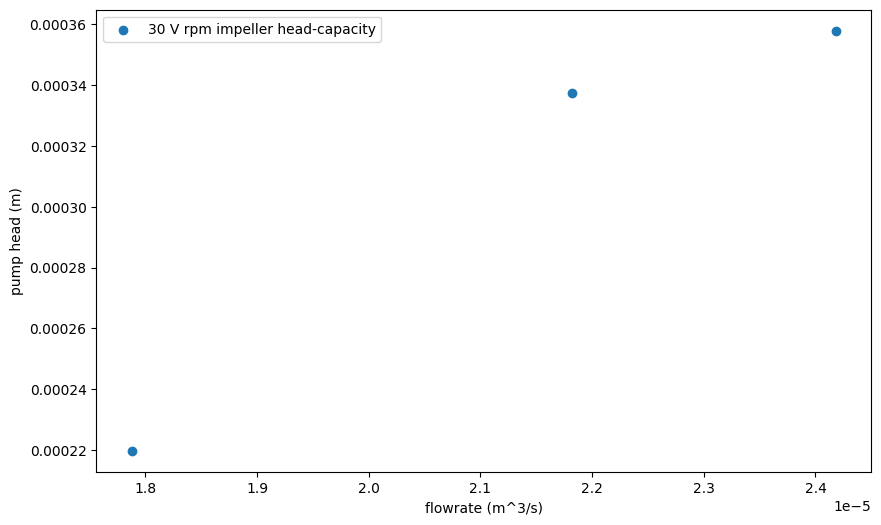

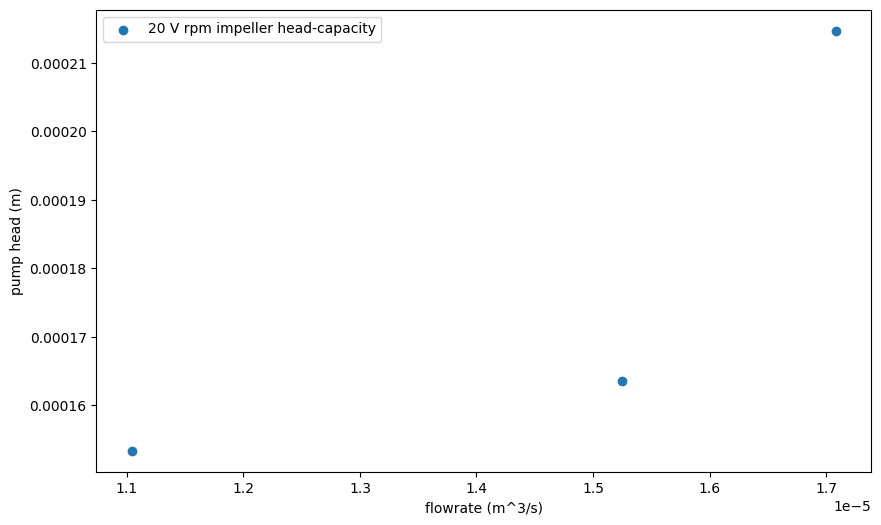

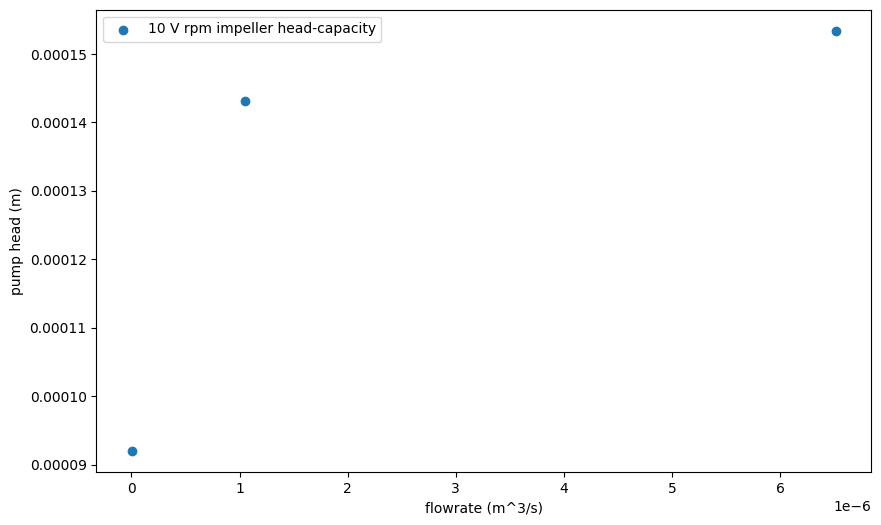

In [156]:
for speed in df["motor_speed"].unique():
    df_speed = df.query("motor_speed == @speed")
    plt.figure(figsize=(10,6))
    plt.scatter(df_speed["volumetric_flowrate"], df_speed["pump_head"], marker="o", label=f"{speed} V rpm impeller head-capacity")
    plt.legend()
    plt.xlabel("flowrate (m^3/s)")
    plt.ylabel("pump head (m)")
    plt.show()

Now let's vary this at different impeller diameters

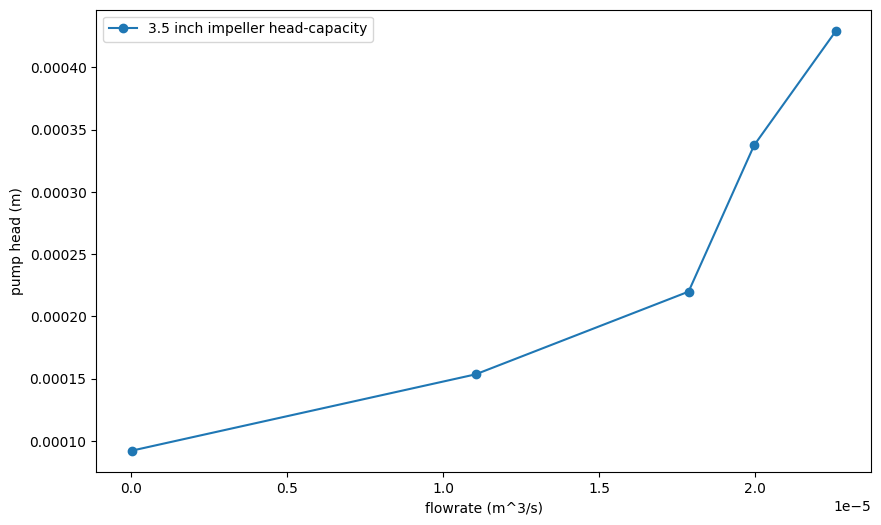

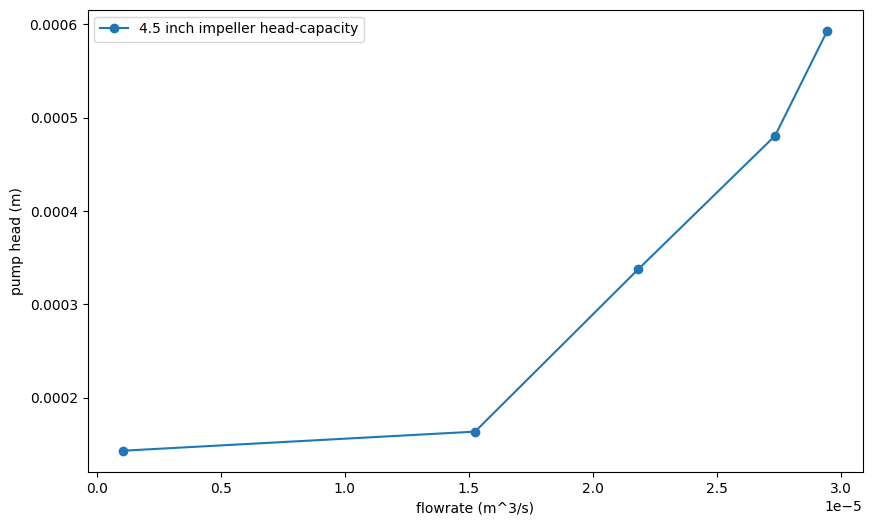

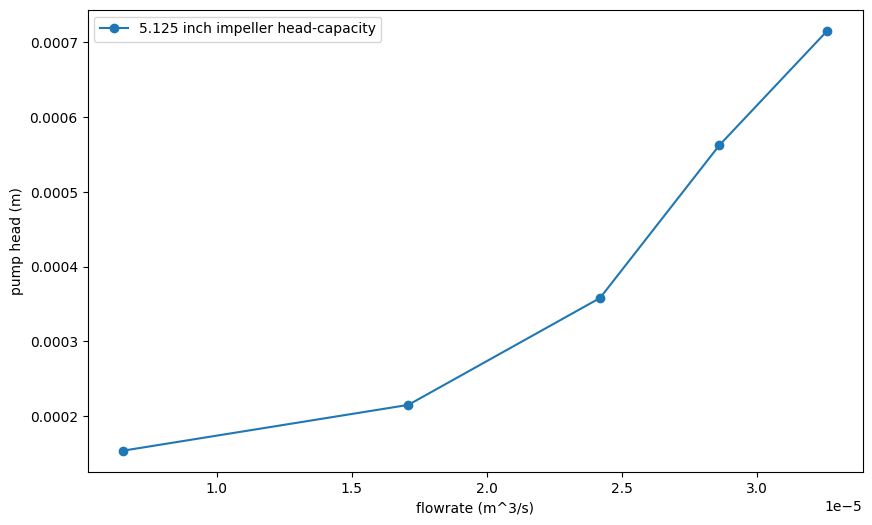

In [157]:
for diam in df["impeller_diam"].unique():
    df_diam = df.query("impeller_diam == @diam")
    plt.figure(figsize=(10,6))
    plt.plot(df_diam["volumetric_flowrate"], df_diam["pump_head"], marker="o", label=f"{diam} inch impeller head-capacity")
    plt.legend()
    plt.xlabel("flowrate (m^3/s)")
    plt.ylabel("pump head (m)")
    plt.show()


$$ \textbf{Describe qualitatively the effect of impeller diameter on the
head-capacity relationship. Can you describe this relationship quantitatively?}$$

Do this later

## Analysis Question 3
$$ \textbf{For the larger impeller at the highest speed, plot the
observed head versus capacity and the relationship predicted by the analysis of the
ideal pump.}$$

We start by finding the ideal pump head-capacity relationship which is given by the equation at (McCabe-Smith, 200)

(3.1):
$$H_r = \frac{u_2 (u_2 - \frac{q_r}{A_p} \tan(\beta_2))}{g_c} $$ 


we have all of these values except for u_2 which is the peripheral velocity, which is defined as:

(3.2):
$$ u_r = r_{impeller} \times \omega $$ 

So, we need to get angular velocity (omega) in rad/s using torque through the below relationship:

(3.3):
$$ \omega = \frac{2\pi (fpm)}{60}$$ 



In [158]:
df["angular_velocity"] = 2 * np.pi * df["ext_fpm"] / 60 # 3.3

In [159]:
df["peripheral_velocity"] = df["angular_velocity"] * df["impeller_diam_meters"] / 2 # 3.2

Let's add the angle data for each impeller from the lab manual

In [160]:
def get_beta(diam):
    if diam == 3.500:
        return 17
    elif diam == 4.500:
        return 20
    elif diam == 5.125:
        return 19

In [161]:
df["beta"] = df["impeller_diam"].apply(get_beta)
df["beta_rad"] = df["beta"] * np.pi / 180

Finally, we compute ideal pump head in 

In [162]:
df["ideal_pump_head"] = (df["peripheral_velocity"] * (df["peripheral_velocity"] - (df["volumetric_flowrate"] / (np.pi * (df["impeller_diam_meters"] / 2) ** 2) * np.tan(df["beta_rad"])))) / g # 3.1

In [163]:
df

,impeller_diam,motor_speed,ext_fpm,field_voltage,armature_voltage,field_current,armature_current,pump_suction_pressure,pump_discharge_pressure,drive_shaft_torque,flowrate,volumetric_flowrate,impeller_diam_meters,pump_head,angular_velocity,peripheral_velocity,beta,beta_rad,ideal_pump_head
0,3.500,50,2907.8,139,134,280,2.20,1.3,5.50,5.00,21.5000,2.260725e-05,0.088900,0.000429,304.504104,13.535234,17,0.296706,18.673548
1,3.500,40,2317.5,139,107,280,1.89,1.7,5.00,3.20,19.0000,1.997850e-05,0.088900,0.000337,242.688032,10.787505,17,0.296706,11.861329
2,3.500,30,1717.9,139,81,280,1.38,2.1,4.25,2.00,17.0000,1.787550e-05,0.088900,0.000220,179.898067,7.996485,17,0.296706,6.517506
3,3.500,20,1120.2,138,54,280,1.10,2.5,4.00,1.00,10.5000,1.104075e-05,0.088900,0.000153,117.307070,5.214310,17,0.296706,2.771273
4,3.500,10,519.2,138,22,280,0.80,2.6,3.50,0.95,0.0014,1.472100e-09,0.088900,0.000092,54.370497,2.416773,17,0.296706,0.595392
5,4.500,50,2770.0,140,130,300,3.60,1.0,6.80,10.50,28.0000,2.944200e-05,0.114300,0.000593,290.073722,16.577746,20,0.349066,28.012677
6,4.500,40,2252.0,140,105,290,2.62,1.1,5.80,7.00,26.0000,2.733900e-05,0.114300,0.000481,235.828889,13.477648,20,0.349066,18.515181
7,4.500,30,1673.5,140,80,290,1.90,1.7,5.00,4.00,20.7500,2.181863e-05,0.114300,0.000337,175.248510,10.015472,20,0.349066,10.224458
8,4.500,20,1074.8,140,50,285,1.30,2.4,4.00,2.00,14.5000,1.524675e-05,0.114300,0.000164,112.552793,6.432405,20,0.349066,4.217365
9,4.500,10,487.8,140,25,285,1.00,2.6,4.00,1.00,1.0000,1.051500e-06,0.114300,0.000143,51.082297,2.919359,20,0.349066,0.868761


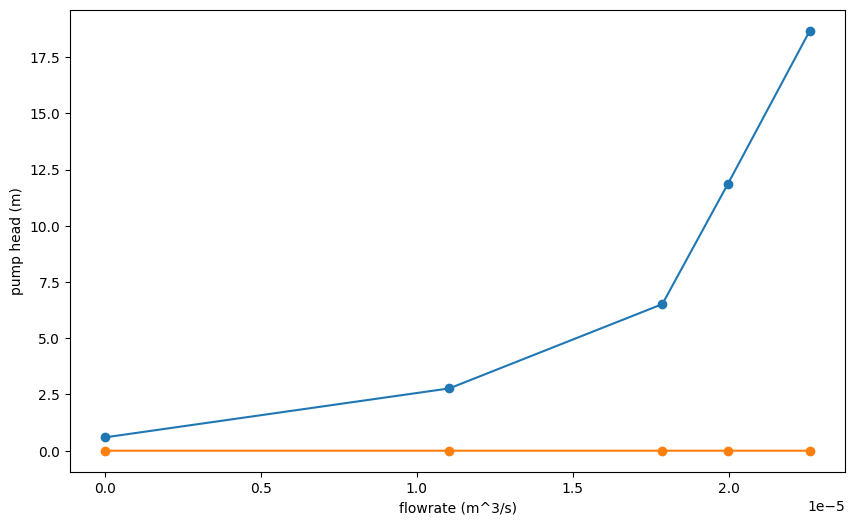

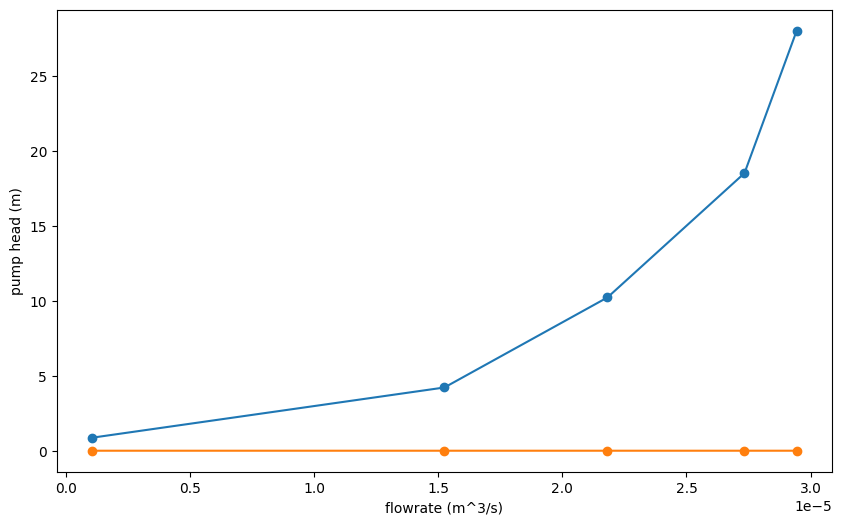

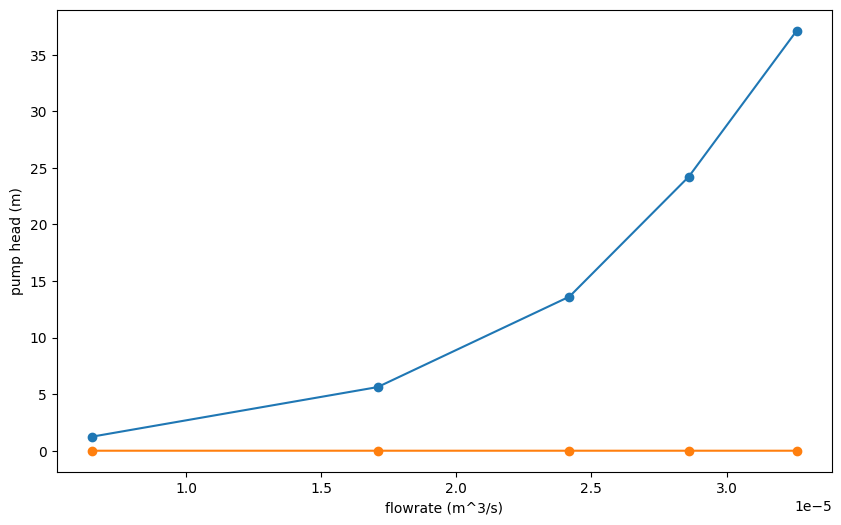

In [164]:
for diam in df["impeller_diam"].unique():
    df_diam = df.query("impeller_diam == @diam")    
    plt.figure(figsize=(10,6))
    plt.xlabel("flowrate (m^3/s)")
    plt.ylabel("pump head (m)")
    plt.plot(df_diam["volumetric_flowrate"], df_diam["ideal_pump_head"], marker="o", label="ideal pump head vs rotational speed")
    plt.plot(df_diam["volumetric_flowrate"], df_diam["pump_head"], marker="o", label="experimental pump head vs rotational speed")
    plt.show()

### Analysis Question 4

The reference of Streeter describes a way of plotting non-dimensional head as a
function of capacity. Dimensionless analysis is a very powerful way to correlate data
when you do not know the governing physical relationships. If you select the correct
dimensionless groups, all of the data can be correlated by a single equation, or by a
characteristic curve. However, selection of inappropriate dimensionless groups will not
allow all of the data to be explained by a single relationship. For a single impeller size,
plot dimensionless head as a function of dimensionless flow for all speeds using the
non-dimensional groups of Streeter. Usually, this gives a single line with little scatter
for each of the impellers. What does this tell you about your understanding of the effect
of rotational speed?

#### Head Coefficient
$$ \psi = \frac{gH}{\omega^2D^2} $$
where $g$ is the gravitational constant $[m/s^2]$, $H$ is the head $[m]$, $\omega$ is rotational speed $[rad/s]$, and $D$ is the diameter $[m]$.
#### Flow Coefficient
$$ \phi = \frac{Q}{\omega D^3} $$
where $Q$ is flow rate $[m^3/s]$, $\omega$ is the rotational speed $[rad/s]$, and $D$ is the diameter $[m]$.

#### Specific Rotational Speed

$$ \omega_{sp} = \frac{\omega \sqrt{Q}}{(gH)^{3/4}} $$

Specific speed characterizes the type of pump.

#### There is also Equation 8.15 from the McCabe textbook
$$ \Delta H_r = \frac{u_2(u_2-q_r/A_p tan \beta_2)}{g_c} $$